# core

> The plotting functions

In [ ]:
# | default_exp core

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import os
from pathlib import Path
from typing import Tuple, Union

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib import pyplot as plt

from geneorder import util

In [ ]:
# | hide
if "EXAMPLE_DATA_PATH" not in os.environ.keys():
    os.environ["EXAMPLE_DATA_PATH"] = (
        "/Users/npapadop/Documents/repos/geneorder/example_data/"
    )

Before we get started with plotting, we should read in some toy data. This is a modified excerpt
from the _P. litorale_ genome annotation, specifically the part that holds the Hox gene cluster.

In [ ]:
gff = util.read_gff(os.environ["EXAMPLE_DATA_PATH"] + "plit.gff3")
util.decorate(gff, attributes={"gene_id": "ID", "gene_name": "gene"})

hox_genes = [
    "PB.8615",
    "g9718",
    "PB.8616",
    "g9720",
    "g9721",
    "PB.8617",
    "g9723",
    "g9724",
    "g9725",
]
keep = gff["gene_id"].isin(hox_genes)
hox = gff[keep].reset_index(drop=True)

In [ ]:
# | export


def plot_synteny(
    gff,  # a GFF in Pandas dataframe form. Only includes the genes of the syntenic block in question.
    block_start: int = None,  # The start coordinate of the syntenic locus to plot. If None, will be set to the start of the first gene minus 5% of the block length.
    block_end: int = None,  # The end coordinate of the syntenic locus to plot. If None, will be set to the end of the last gene plus 5% of the block length.
    figsize: (float, float) = None,  # the figure size.
    locus_start: str = "start",  # the GFF column that describes the start coordinate of the entities (e.g. gene, mRNA) to be plotted on the chromosome. In a well-behaved GFF, this should be "start".
    locus_end: str = "end",  # the GFF column that describes the end coordinate of the entities (e.g. gene, mRNA) to be plotted on the chromosome. In a well-behaved GFF, this should be "end".
    molecule: str = "seqid",  # the GFF column that holds the molecule name (chromosome/scaffold/contig ID). In a well-behaved GFF, this should be "seqid".
    locus_name: str = "gene_name",  # the GFF column that holds the gene/mRNA symbol. This is usually a tag in the "attributes" column of a well-behaved GFF and should have been extracted prior to this step. It will be plotted according to the `gene_name_offset` parameter.
    fig_title: str = None,  # Figure title.
    save: str | Path = "synteny.svg",  # path to save an SVG image.
    palette: (
        dict | None
    ) = mcolors.CSS4_COLORS,  # color palette in dictionary form. If None, the color column is expected to be a string that can be interpreted as color.
    chromosome_color: str = "lightgray",  # the color of the line representing the molecule the genes are plotted on.
    backup_gene_color: str = "darkgray",  # If the GFF has no column titled "color", the gene arrows will be filled using this color.
    gene_name_offset: float = 0.02,  # Default offset for plotting gene names if the GFF has no column titled "offset".
    chromosome_width: float = 1,  # Linewidth parameter for the line representing the chromosome.
    gene_width: float = 5,  # Width of the arrow patches representing genes. Please refer to the documentation of `matplotlib.pyplot.arrow` for more details.
) -> None:
    "Function to plot a syntenic cluster of genes."

    if len(gff[molecule].unique()) > 1:
        raise ValueError(
            f"There are multiple molecules represented in the input GFF: {gff[molecule].unique()}. Please only input a GFF with genes on a single molecule."
        )

    if block_start is None or block_end is None:
        block_start, block_end = util.syntenic_block_borders(gff)

    if figsize is None:
        figsize = util.estimate_plot_size(gff)

    fig, ax = plt.subplots(figsize=figsize)

    # plot contig
    ax.plot(
        [block_start, block_end],
        [0, 0],
        color=chromosome_color,
        linewidth=chromosome_width,
    )
    for name, gene in gff.iterrows():
        start = gene[locus_start]
        end = gene[locus_end]
        if "color" in gene.index:
            if palette is not None:
                color = mcolors.CSS4_COLORS[gene["color"]]
            else:
                color = gene["color"]
        else:
            color = backup_gene_color

        if "offset" in gene.index:
            offset = gene["offset"]
        else:
            offset = gene_name_offset

        if gene["strand"] == "-":
            arrow_from = end
            arrow_to = start - end - 1000
        else:
            arrow_from = start
            arrow_to = end - start + 1000

        ax.arrow(
            arrow_from,
            0,
            arrow_to,
            0,
            head_width=0.05,
            head_length=1000,
            fc=color,
            ec=color,
            linewidth=gene_width,
        )
        ax.text(
            gene[locus_start] - 10000,
            offset * 20,
            gene[locus_name],
            color=color,
            fontsize=10,
        )

    ax.set_yticks([])
    ax.set_ylim(-1.5, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    if fig_title is not None:
        ax.set_title(fig_title)
    plt.gca().set_position([0, 0, 1, 1])
    if save is not None:
        if not (isinstance(save, str) | isinstance(save, Path)):
            raise TypeError(
                f"The save location should be a valid Path or string; instead, it is {type(save)}."
            )
        plt.savefig(save, bbox_inches="tight", pad_inches=0)

We can use this function with any GFF dataframe that is reduced to one row per gene (for example a
`type: gene` or `type: mRNA` entry per gene).

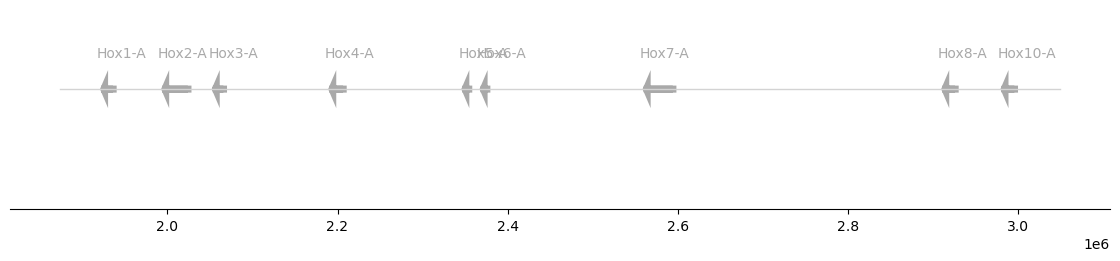

In [ ]:
plot_synteny(hox, figsize=(11, 2))

If the input GFF contains information about the color and the gene name offsets, the plotter will
use them:

In [ ]:
hox["color"] = [
    "red",
    "orange",
    "gold",
    "lightgreen",
    "forestgreen",
    "royalblue",
    "darkblue",
    "darkmagenta",
    "magenta",
]
hox["offset"] = [0.02, -0.025, 0.02, 0.02, 0.02, -0.025, 0.02, 0.02, 0.02]

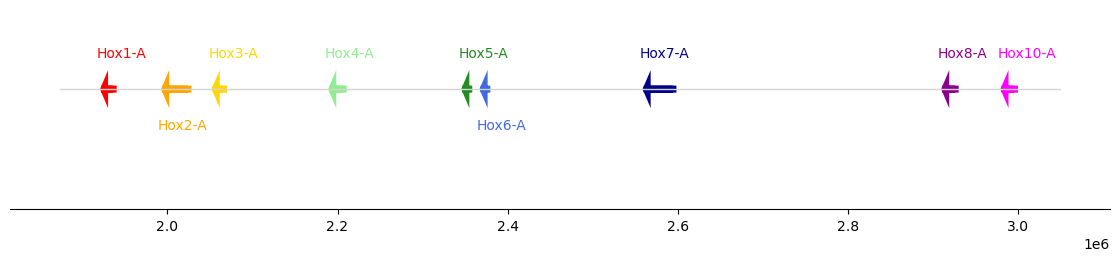

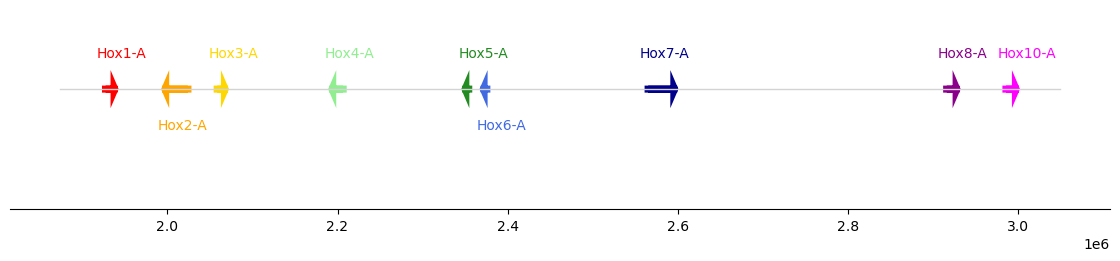

In [ ]:
plot_synteny(hox, figsize=(11, 2))
hox["strand"] = ["+", "-", "+", "-", "-", "-", "+", "+", "+"]
plot_synteny(hox, figsize=(11, 2))

We can also use hex codes directly for coloring:

In [ ]:
hox["color"] = [
    "#E7DAD2",
    "#CFE2B7",
    "#FA7F6F",
    "#83B0D2",
    "#BEB9DC",
    "#C0E59A",
    "#8ECFC9",
    "#FFBE79",
    "#BAAC8C",
]

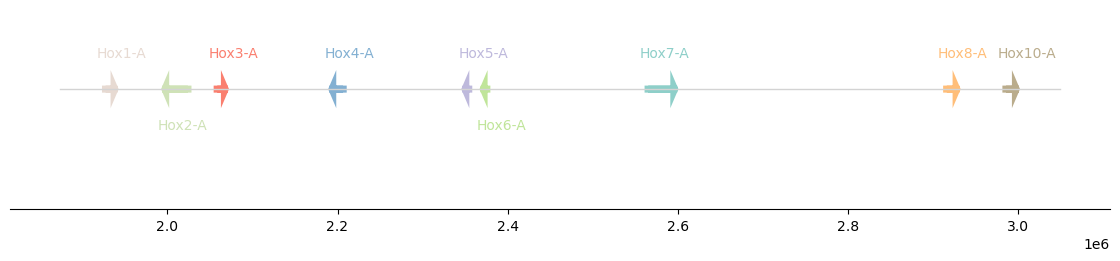

In [ ]:
plot_synteny(hox, figsize=(11, 2), palette=None)

In [ ]:
# | export


def plot_synteny_schematic(
    gff: pd.DataFrame,  # a GFF in Pandas dataframe form. Only includes the genes of the syntenic block in question. Assumed to be sorted in plotting order.
    block_gene: float = 400,  # length of a gene arrow, in plot coordinate space.
    block_dist: float = 200,  # length of gap between successive genes, in plot coordinate space.
    locus_start: str = "start",  # the GFF column that describes the start coordinate of the entities (e.g. gene, mRNA) to be plotted on the chromosome. In a well-behaved GFF, this should be "start".
    locus_end: str = "end",  # the GFF column that describes the end coordinate of the entities (e.g. gene, mRNA) to be plotted on the chromosome. In a well-behaved GFF, this should be "end".
    molecule: str = "seqid",  # the GFF column that holds the molecule name (chromosome/scaffold/contig ID). In a well-behaved GFF, this should be "seqid".
    locus_name: str = "gene_name",  # the GFF column that holds the gene/mRNA symbol. This is usually a tag in the "attributes" column of a well-behaved GFF and should have been extracted prior to this step. It will be plotted according to the `gene_name_offset` parameter.
    interrupted: bool = False,  # is the syntenic cluster on multiple pseudomolecules?
    palette: (
        dict | None
    ) = mcolors.CSS4_COLORS,  # color palette in dictionary form. If None, the color column is expected to be a string that can be interpreted as color.
    fontsize: int = 30,  # this fontsize works well for default sizes, but is probably too big for smaller plots
    chromosome_color: str = "black",  # the color of the line representing the molecule the genes are plotted on.
    backup_gene_color: str = "darkgray",  # If the GFF has no column titled "color", the gene arrows will be filled using this color.
    gene_name_offset: float = 0.02,  # Default offset for plotting gene names if the GFF has no column titled "offset".
    chromosome_width: float = 3,  # Linewidth parameter for the line representing the chromosome; also, patch linewidth of the arrows representing genes. Please refer to the documentation of `matplotlib.patches.FancyArrowPath` for more details.
    head_length: float = 200,  # Head length for the arrows representing genes. Please refer to the documentation of `matplotlib.patches.FancyArrowPath` for more details.
    head_width: float = 1.7,  # Head width for the arrows representing genes. Please refer to the documentation of `matplotlib.patches.FancyArrowPath` for more details.
    gene_width: float = 1,  # Width of the arrow patches representing genes. Please refer to the documentation of `matplotlib.patches.FancyArrowPath` for more details.
    ax: plt.Axes = None,  # a pre-existing matplotlib axes object, if you wish to include this plot in a composite.
    figsize: (
        float,
        float,
    ) = None,  # the figure size. Will be ignored if ax is not None.
    save: str | Path = "schematic.svg",  # path to save an SVG image.
    return_fig: bool = False,  # whether to return an axes object. Useful for further manipulation of the plot.
) -> plt.Figure | plt.Axes | None:
    # 'Function to plot a syntenic cluster of genes. Each gene is represented by an arrow; left-facing arrows indicate a minus orientation, and right-facing arrows a plus orientation. The genes can be colored using named colors from the `matplotlib.colors.CSS4_COLORS` collection.'

    if len(gff[molecule].unique()) > 1:
        if not interrupted:
            raise ValueError(
                f"There are multiple molecules represented in the input GFF: {gff[molecule].unique()}. Please only input a GFF with genes on a single molecule."
            )

    if figsize is None:
        figsize = util.estimate_plot_size(gff)

    fig, ax = plt.subplots(figsize=figsize)
    # the total length is:
    # - the number of gene blocks
    # - the number of gaps between genes (number of gene blocks - 1)
    # - the start and end gap
    gff_genes = gff[gff[molecule] != ""]
    total_length = (
        (len(gff_genes) * block_gene)
        + (2 * block_dist)
        + ((len(gff_genes) - 1) * block_dist)
    )
    # plot contig
    ax.plot(
        [0, total_length], [0, 0], color=chromosome_color, linewidth=chromosome_width
    )
    start = 0
    end = 0
    genes_seen = 0
    for i, gene in gff.iterrows():
        if gene[molecule] != "":
            genes_seen += 1
        if gene[locus_start] == "":
            # as many gene blocks as we walked, plus as many gaps minus one
            break_start = (genes_seen) * block_gene + (genes_seen + 0.2) * block_dist
            break_end = break_start + 0.6 * block_dist
            ax.plot(
                [break_start, break_end],
                [0, 0],
                color="white",
                linewidth=chromosome_width + 2,
            )
            offset = gene_name_offset
            continue

        start = end + block_dist
        end = start + block_gene
        if "color" in gene.index:
            if gene["color"] == "":
                continue
            if palette is not None:
                color = mcolors.CSS4_COLORS[gene["color"]]
            else:
                color = gene["color"]
        else:
            color = backup_gene_color

        if "offset" in gene.index:
            offset = gene["offset"]
        else:
            offset = gene_name_offset

        # Draws an arrow from (x, y) to (x + dx, y + dy). The width of the arrow is scaled by width
        if gene["strand"] == "-":
            arrow_from = end
            arrow_to = start - end + head_length
        else:
            arrow_from = start
            arrow_to = end - start - head_length

        arrow = mpatches.FancyArrow(
            arrow_from,
            0,
            arrow_to,
            0,
            width=gene_width,
            head_length=head_length,
            head_width=head_width,
            ec="black",
            fc=color,
            lw=chromosome_width,
            zorder=2,
            head_starts_at_zero=False,
        )
        ax.add_patch(arrow)
        # ax.arrow(end, 0, start-end-100, 0, head_width=0.05, head_length=100, fc=color, ec=color, linewidth=gene_width)
        ax.text(
            end - block_gene,
            offset * 60,
            gene[locus_name],
            color="black",
            fontsize=fontsize,
        )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-1.5, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    plt.gca().set_position([0, 0, 1, 1])
    if save is not None:
        if not (isinstance(save, str) | isinstance(save, Path)):
            raise TypeError(
                f"The save location should be a valid Path or string; instead, it is {type(save)}."
            )
        plt.savefig(save, bbox_inches="tight", pad_inches=0)

    if return_fig:
        return ax

In [ ]:
hox["color"] = [
    "red",
    "orange",
    "gold",
    "lightgreen",
    "forestgreen",
    "royalblue",
    "darkblue",
    "darkmagenta",
    "magenta",
]
hox["offset"] = 0.02
hox["strand"] = "-"

Sometimes (many times) we are not interested in plotting syntenic genes with their real distances;
rather, we are interested in the order and orientation of the genes. This representation can be
achieved with the `plot_synteny_schematic` function, that can process the same sort of input as 
`plot_synteny`.

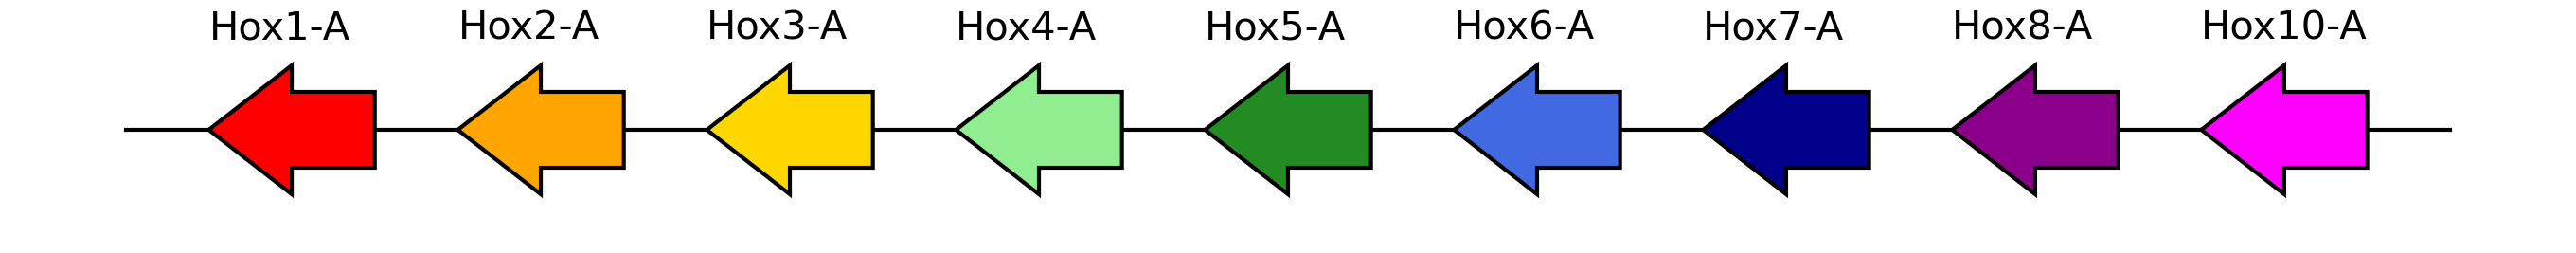

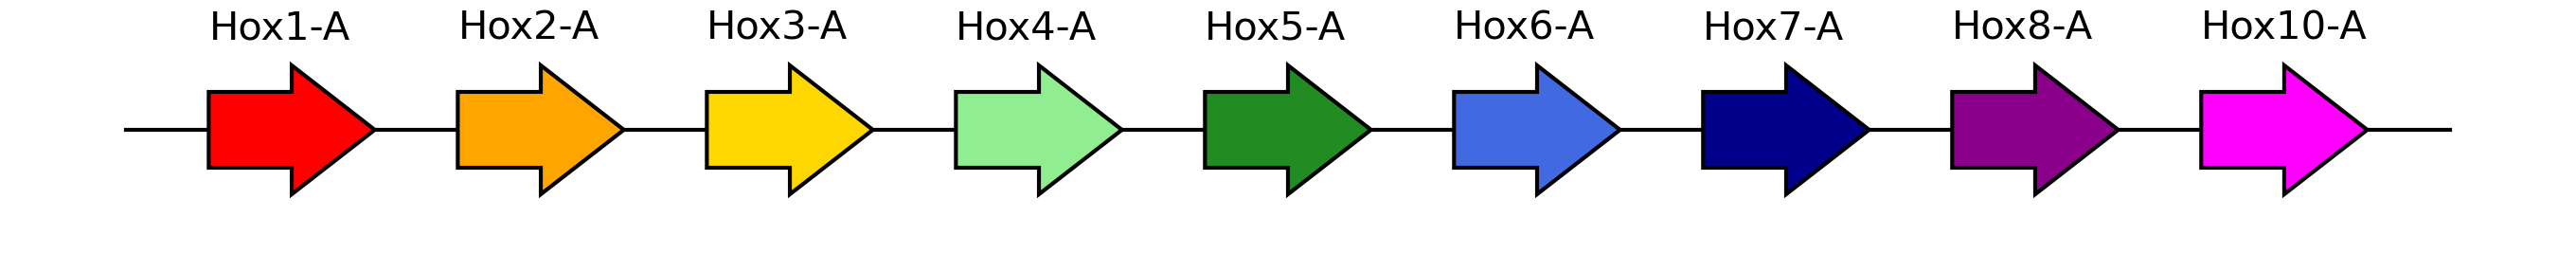

In [ ]:
plot_synteny_schematic(hox)
hox["strand"] = "+"
plot_synteny_schematic(hox)

The keen reader will have noticed that there is no gap between Hox8 and Hox10 - even though Hox9 is
missing. We can edit the GFF dataframe to amend this:

In [ ]:
hox = util.insert_gap(
    hox,
    "g9724",
    "g9725",
    "gene_id",
    no_gaps=1,
    purge_columns=["gene_name", "color", "offset", "attributes"],
)

In [ ]:
hox

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,gene_name,color,offset
0,pseudochrom_56,PacBio,gene,1927066,1936157,.,+,.,ID=PB.8615;function=Homeobox domain;gene=Hox1-...,PB.8615,Hox1-A,red,0.02
1,pseudochrom_56,AUGUSTUS,gene,1998922,2024148,.,+,.,ID=g9718;function=sequence-specific DNA bindin...,g9718,Hox2-A,orange,0.02
2,pseudochrom_56,PacBio,gene,2058396,2065953,.,+,.,ID=PB.8616;function=homeobox protein;gene=Hox3...,PB.8616,Hox3-A,gold,0.02
3,pseudochrom_56,AUGUSTUS,gene,2195412,2206712,.,+,.,ID=g9720;function=sequence-specific DNA bindin...,g9720,Hox4-A,lightgreen,0.02
4,pseudochrom_56,AUGUSTUS,gene,2351936,2354374,.,+,.,ID=g9721;function=sequence-specific DNA bindin...,g9721,Hox5-A,forestgreen,0.02
5,pseudochrom_56,PacBio,gene,2373415,2375678,.,+,.,ID=PB.8617;function=sequence-specific DNA bind...,PB.8617,Hox6-A,royalblue,0.02
6,pseudochrom_56,AUGUSTUS,gene,2565196,2594468,.,+,.,ID=g9723;function=sequence-specific DNA bindin...,g9723,Hox7-A,darkblue,0.02
7,pseudochrom_56,AUGUSTUS,gene,2916314,2926445,.,+,.,ID=g9724;function=sequence-specific DNA bindin...,g9724,Hox8-A,darkmagenta,0.02
8,pseudochrom_56,AUGUSTUS,gene,2926446,2926447,.,+,.,,gap_g9724-0,,,
9,pseudochrom_56,AUGUSTUS,gene,2986021,2996225,.,+,.,ID=g9725;function=sequence-specific DNA bindin...,g9725,Hox10-A,magenta,0.02


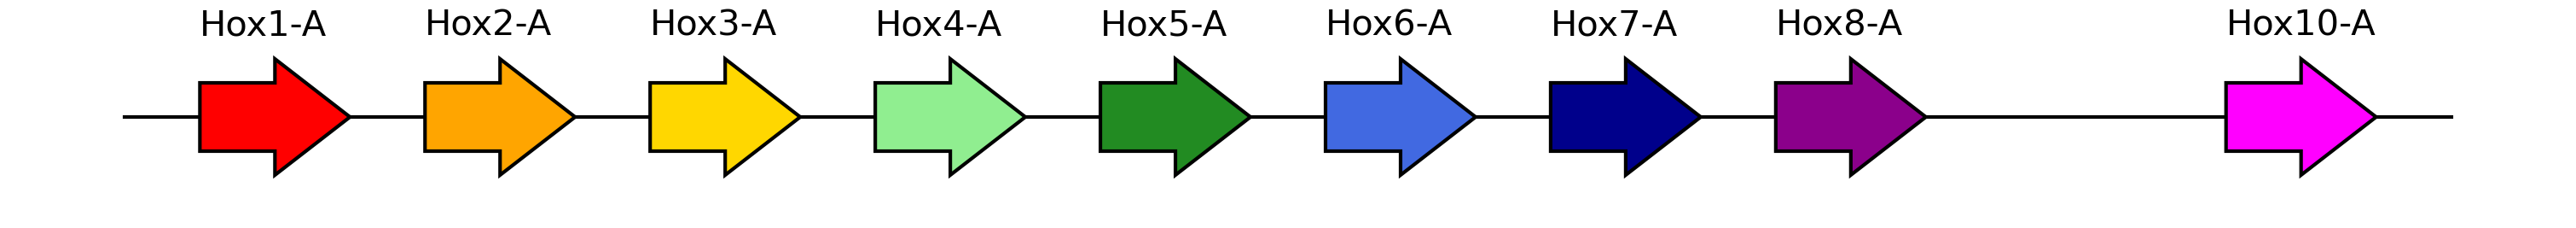

In [ ]:
plot_synteny_schematic(hox)

This approach becomes even more powerful when we are plotting the same cluster in different
instances, for example when there is a duplication of the cluster:

In [ ]:
on_chrom12 = gff["seqid"] == "pseudochrom_12"
is_gene = gff["type"] == "gene"

hoxb = gff[on_chrom12 & is_gene].copy().reset_index(drop=True)
hoxb["color"] = ["red", "orange", "darkblue", "magenta"]
hoxb

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,gene_name,color
0,pseudochrom_12,PacBio,gene,1927066,1936157,.,-,.,ID=PB.9615;function=Homeobox domain;gene=Hox1-...,PB.9615,Hox1-B,red
1,pseudochrom_12,AUGUSTUS,gene,1998922,2024148,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,g7718,Hox2-B,orange
2,pseudochrom_12,AUGUSTUS,gene,2565196,2594468,.,-,.,ID=g7723;function=sequence-specific DNA bindin...,g7723,Hox7-B,darkblue
3,pseudochrom_12,AUGUSTUS,gene,2986021,2996225,.,-,.,ID=g7725;function=sequence-specific DNA bindin...,g7725,Hox10-B,magenta


This cluster is missing Hox genes 3-6 and 8-9; we should add the corresponding number of gaps in
order for the plots to line up accordingly:

In [ ]:
hoxb = util.insert_gap(
    hoxb, "g7718", "g7723", "gene_id", no_gaps=4, purge_columns=["gene_name", "color"]
)
hoxb = util.insert_gap(
    hoxb, "g7723", "g7725", "gene_id", no_gaps=2, purge_columns=["gene_name", "color"]
)
hoxb

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,gene_name,color
0,pseudochrom_12,PacBio,gene,1927066,1936157,.,-,.,ID=PB.9615;function=Homeobox domain;gene=Hox1-...,PB.9615,Hox1-B,red
1,pseudochrom_12,AUGUSTUS,gene,1998922,2024148,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,g7718,Hox2-B,orange
2,pseudochrom_12,AUGUSTUS,gene,2024149,2024150,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,gap_g7718-0,,
3,pseudochrom_12,AUGUSTUS,gene,2024151,2024152,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,gap_g7718-1,,
4,pseudochrom_12,AUGUSTUS,gene,2024153,2024154,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,gap_g7718-2,,
5,pseudochrom_12,AUGUSTUS,gene,2024155,2024156,.,-,.,ID=g7718;function=sequence-specific DNA bindin...,gap_g7718-3,,
6,pseudochrom_12,AUGUSTUS,gene,2565196,2594468,.,-,.,ID=g7723;function=sequence-specific DNA bindin...,g7723,Hox7-B,darkblue
7,pseudochrom_12,AUGUSTUS,gene,2594469,2594470,.,-,.,ID=g7723;function=sequence-specific DNA bindin...,gap_g7723-0,,
8,pseudochrom_12,AUGUSTUS,gene,2594471,2594472,.,-,.,ID=g7723;function=sequence-specific DNA bindin...,gap_g7723-1,,
9,pseudochrom_12,AUGUSTUS,gene,2986021,2996225,.,-,.,ID=g7725;function=sequence-specific DNA bindin...,g7725,Hox10-B,magenta


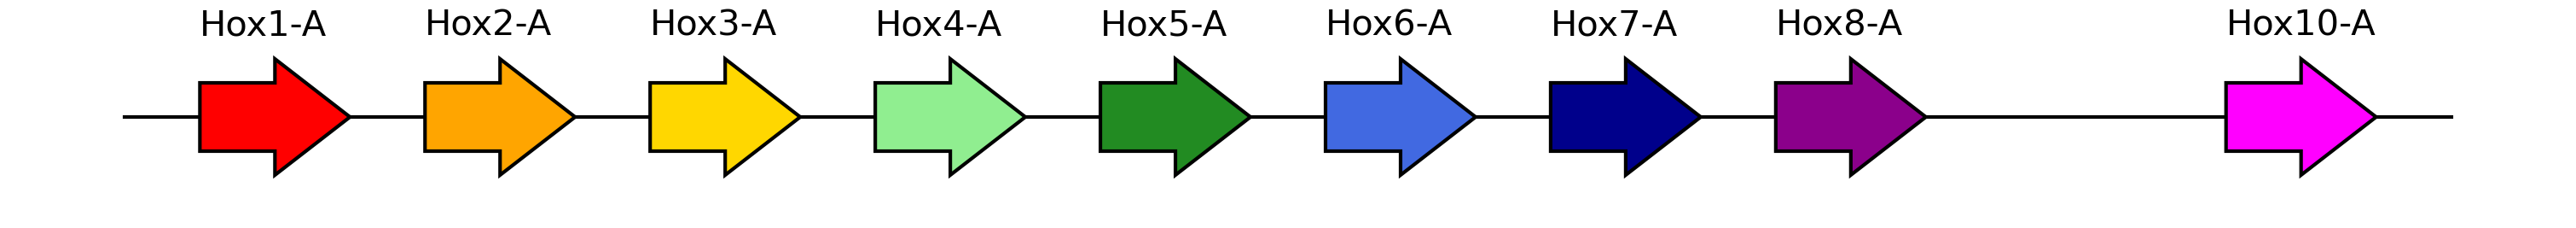

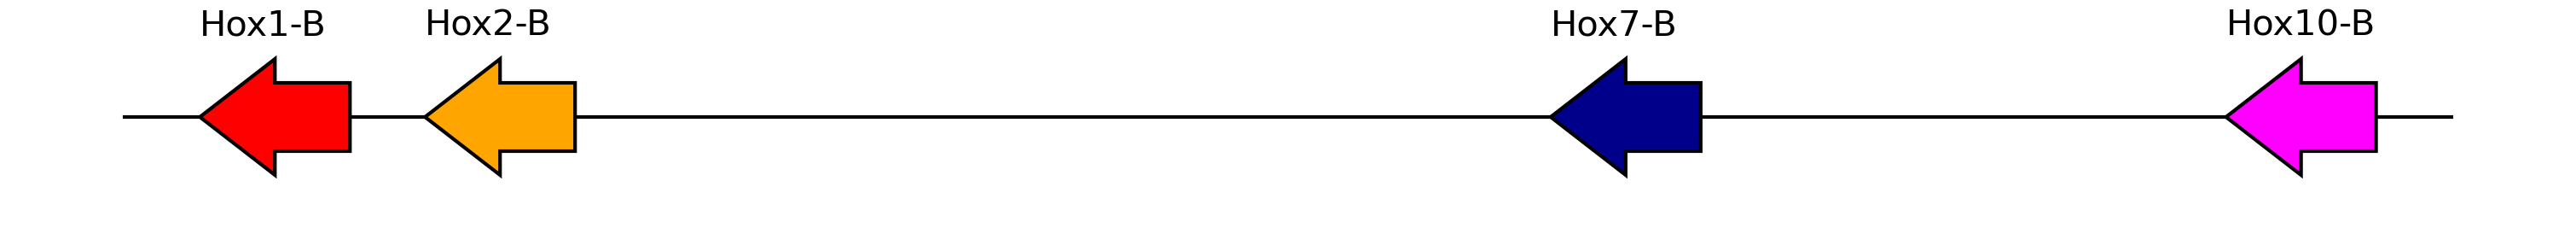

In [ ]:
plot_synteny_schematic(hox)
plot_synteny_schematic(hoxb)

Sometimes we want to plot genes that belong to the same cluster but because of assembly fragmentation they are not on the same pseudomolecule.

In [ ]:
on_scaff44 = gff["seqid"] == "scaffold_44"
is_gene = gff["type"] == "gene"

hoxc = gff[on_scaff44 & is_gene].copy().reset_index(drop=True)
hoxc["color"] = ["dodgerblue", "hotpink"]

interrupted = pd.concat((hox.loc[6:], hoxc)).reset_index(drop=True)
interrupted["offset"] = 0.02
interrupted = util.insert_break(interrupted, locus1="g9725", locus2="PB.1762")
interrupted

,seqid,source,type,start,end,score,strand,phase,attributes,gene_id,gene_name,color,offset
0,pseudochrom_56,AUGUSTUS,gene,2565196,2594468,.,+,.,ID=g9723;function=sequence-specific DNA bindin...,g9723,Hox7-A,darkblue,0.02
1,pseudochrom_56,AUGUSTUS,gene,2916314,2926445,.,+,.,ID=g9724;function=sequence-specific DNA bindin...,g9724,Hox8-A,darkmagenta,0.02
2,pseudochrom_56,AUGUSTUS,gene,2926446,2926447,.,+,.,,gap_g9724-0,,,0.02
3,pseudochrom_56,AUGUSTUS,gene,2986021,2996225,.,+,.,ID=g9725;function=sequence-specific DNA bindin...,g9725,Hox10-A,magenta,0.02
4,,,,,,,,,,break,,,
5,scaffold_44,PacBio,gene,1927066,1936157,.,-,.,ID=PB.1762;function=Homeobox domain;gene=Hox11...,PB.1762,Hox11,dodgerblue,0.02
6,scaffold_44,AUGUSTUS,gene,1998922,2024148,.,-,.,ID=g13061;function=sequence-specific DNA bindi...,g13061,Hox12,hotpink,0.02


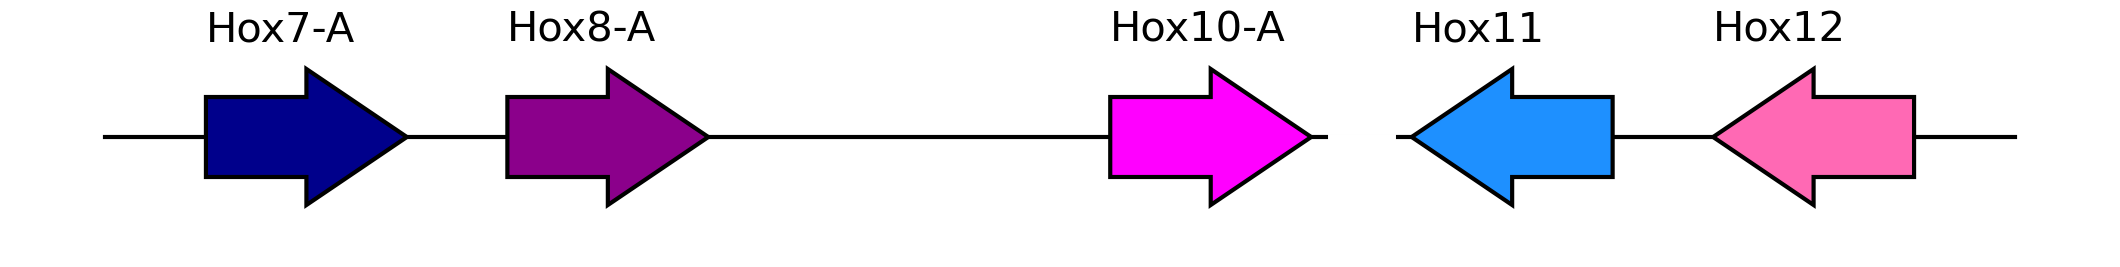

In [ ]:
plot_synteny_schematic(interrupted, interrupted=True)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()